In [1]:
# Extracao de dados de patentes
# url - www.freepatentsonline.com
#
# Henrique Cursino Vieira
# versao 0.1 

In [1]:
# dataframe
import re
import pandas as pd

# webscraping
import requests
from bs4 import BeautifulSoup

# nuvem de palavras
from wordcloud import WordCloud

In [2]:
# cada pagina lista 50 patentes, alterar a variavel n para obter o numero de
# patentes de interesse
p = 20

In [3]:
# Nome das colunas
columns = ["Match", "Document", "Document_Title", "Score"]

In [5]:
rows = []
for pagina in range(1,p+1):
    print(pagina)
    pagina = str(pagina)
    link = "https://www.freepatentsonline.com/result.html?p={}&sort=relevance&srch=top&query_txt=agronomy&patents_us=on".format(pagina)
    
    page = requests.get(link)
    soup = BeautifulSoup(page.content, 'html.parser')
    
    # Capturando o conteudo da tag <td> e pulando as duas primeiras tags
    listing_table = soup.findAll("td")[2:202]    
    
    for i in range(0, len(listing_table), 4):

    #     print(i)
        match, document, document_title, score = listing_table[i:i+4]
        rows.append([match, document, document_title, score])  

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [6]:
print('Total de linhas:', len(rows))

Total de linhas: 1000


In [7]:
# Verificando o conteudo
listing_table[6]

<td valign="top" width="60%">
<a href="/9320225.html">Plants and seeds of hybrid corn variety CH966110</a>
         
                            <br/>
                According to the invention, there is provided seed and plants of the hybrid corn variety designated CH966110. The invention thus relates to the plants, seeds and tissue cultures of the variety...    </td>

In [8]:
rows[5][2].findAll('a')

[<a href="/y2003/0125877.html">Methods and systems for managing farmland</a>]

In [9]:
# lista de links
urls = []
for i in range(len(rows)):

    td = rows[i][2]
    a = td.findAll('a')
    
    if a:
        urls.append("https://www.freepatentsonline.com"+a[0].get('href'))

In [10]:
len(urls)

1000

In [42]:
# extraindo os dados dos documentos de patentes
tmp = dict()

start = 0 # 0
for i, url in enumerate(urls[start:]):
    
    i = i+start
    print('process', i)
    
    tmp[i] = []
    url_splited = url.split('/')
    
    if len(url_splited) == 4:
        idx = url_splited[3].replace('.html', '')
        
    if len(url_splited) == 5:
        idx = url_splited[4].replace('.html', '')

    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    
    tmp[i].append(['idx', idx])
    
    for row in soup.findAll("div", {"class":"disp_doc2"}):
        
        title_content = row.findAll("div", {"class":"disp_elm_title"})
        text_content = row.findAll("div", {"class":"disp_elm_text"})
        title = None
        text = None
        
        if title_content:
            title = title_content[0].text

            if text_content:
                text = text_content[0].text

            tmp[i].append([title, text])
            
    if i%100 == 0:
        
        rows = []
        for i in tmp.keys():
            row_ = [tmp[i][0][1], tmp[i][1][1], tmp[i][2][1]]
            rows.append(row_)

        data = pd.DataFrame(rows, columns = ['idx', 'title_raw', 'text_raw'])
        data.to_csv('tmp/'+str(i)+'.csv', index = False)
        


process 900
process 901
process 902
process 903
process 904
process 905
process 906
process 907
process 908
process 909
process 910
process 911
process 912
process 913
process 914
process 915
process 916
process 917
process 918
process 919
process 920
process 921
process 922
process 923
process 924
process 925
process 926
process 927
process 928
process 929
process 930
process 931
process 932
process 933
process 934
process 935
process 936
process 937
process 938
process 939
process 940
process 941
process 942
process 943
process 944
process 945
process 946
process 947
process 948
process 949
process 950
process 951
process 952
process 953
process 954
process 955
process 956
process 957
process 958
process 959
process 960
process 961
process 962
process 963
process 964
process 965
process 966
process 967
process 968
process 969
process 970
process 971
process 972
process 973
process 974
process 975
process 976
process 977
process 978
process 979
process 980
process 981
process 982
proc

In [53]:
# Ao termino, juntar os dados

import glob

data = pd.DataFrame()
for path in glob.glob('tmp/patents/*'):

    tmp_data = pd.read_csv(path)
    data = pd.concat([data, tmp_data])
data = data.drop_duplicates()
data.shape

(904, 3)

In [54]:
data.head(10)

,idx,title_raw,text_raw
0,0387659,\n\n SYSTEMS AND METHODS FO...,\n The present disclosure provides ...
1,10729058,\n\n Systems and methods fo...,\n The present disclosure provides ...
2,6745128,\n\n Methods and systems fo...,\n Methods and systems for characte...
3,6549852,\n\n Methods and systems fo...,\n Methods and systems for characte...
4,0018431,\n\n METHODS AND SYSTEMS FO...,\n Methods and systems for characte...
5,0125877,\n\n Methods and systems fo...,\n Methods and systems for characte...
6,0155623,\n\n Agronomy bonus system ...,\n A method and system for encourag...
7,10796261,\n\n Agricultural enterpris...,\n A computer-implemented cloud-bas...
8,0394579,\n\n AGRICU...,\n United State...
9,0322426,\n\n AGRICULTURAL ENTERPRIS...,\n A computer-implemented cloud-bas...


In [55]:
def preprocess_text(text = None):
    
    processed_text = re.sub('\n{1,}', '', text).strip().lower()    
    return processed_text

In [57]:
# pre processamento dos dados e gerando uma coluna unificando titulo e texto
data['title']   = data['title_raw'].apply(lambda x : preprocess_text(x))
data['text']    = data['text_raw'].apply(lambda x : preprocess_text(x))
data['content'] = data['title'] + " " + data['text']
data.head(10)

,idx,title_raw,text_raw,title,text,content
0,0387659,\n\n SYSTEMS AND METHODS FO...,\n The present disclosure provides ...,systems and methods for adjusting the output o...,the present disclosure provides systems and me...,systems and methods for adjusting the output o...
1,10729058,\n\n Systems and methods fo...,\n The present disclosure provides ...,systems and methods for adjusting the output o...,the present disclosure provides systems and me...,systems and methods for adjusting the output o...
2,6745128,\n\n Methods and systems fo...,\n Methods and systems for characte...,methods and systems for managing farmland,methods and systems for characterizing and man...,methods and systems for managing farmland meth...
3,6549852,\n\n Methods and systems fo...,\n Methods and systems for characte...,methods and systems for managing farmland,methods and systems for characterizing and man...,methods and systems for managing farmland meth...
4,0018431,\n\n METHODS AND SYSTEMS FO...,\n Methods and systems for characte...,methods and systems for managing farmland,methods and systems for characterizing and man...,methods and systems for managing farmland meth...
5,0125877,\n\n Methods and systems fo...,\n Methods and systems for characte...,methods and systems for managing farmland,methods and systems for characterizing and man...,methods and systems for managing farmland meth...
6,0155623,\n\n Agronomy bonus system ...,\n A method and system for encourag...,agronomy bonus system and method,a method and system for encouraging farmers to...,agronomy bonus system and method a method and ...
7,10796261,\n\n Agricultural enterpris...,\n A computer-implemented cloud-bas...,agricultural enterprise management method and ...,a computer-implemented cloud-based agricultura...,agricultural enterprise management method and ...
8,0394579,\n\n AGRICU...,\n United State...,agricultural enterprise management method and ...,united states patent application 20200394579 ...,agricultural enterprise management method and ...
9,0322426,\n\n AGRICULTURAL ENTERPRIS...,\n A computer-implemented cloud-bas...,agricultural enterprise management method and ...,a computer-implemented cloud-based agricultura...,agricultural enterprise management method and ...


In [58]:
data['content'].tolist()[10]

'augmented-human field inspection tools for automated phenotyping systems and agronomy tools systems and methods for augmented-human field inspection tools for automated phenotyping systems and agronomy tools. in one embodiment, a method for plant phenotyping, includes: acquiring a first set of observations about plants in a field by a trainer. the trainer carries a sensor configured to collect observations about the plant, and the first set of observations includes ground truth data. the method also includes processing the first set of observations about the plants by a trait extraction model to generate instructions for a trainee; and acquiring a second set of observations about the plants by a trainee while the trainee follows the instructions.'

In [59]:
# nuvem de palavras
text = ', '.join(list(data['content'].values))
wordcloud = WordCloud(background_color="white", 
                      max_words=5000, 
                      contour_width=3, 
                      contour_color='steelblue',
                      width=1200, 
                      height=800,
                      collocations=False)

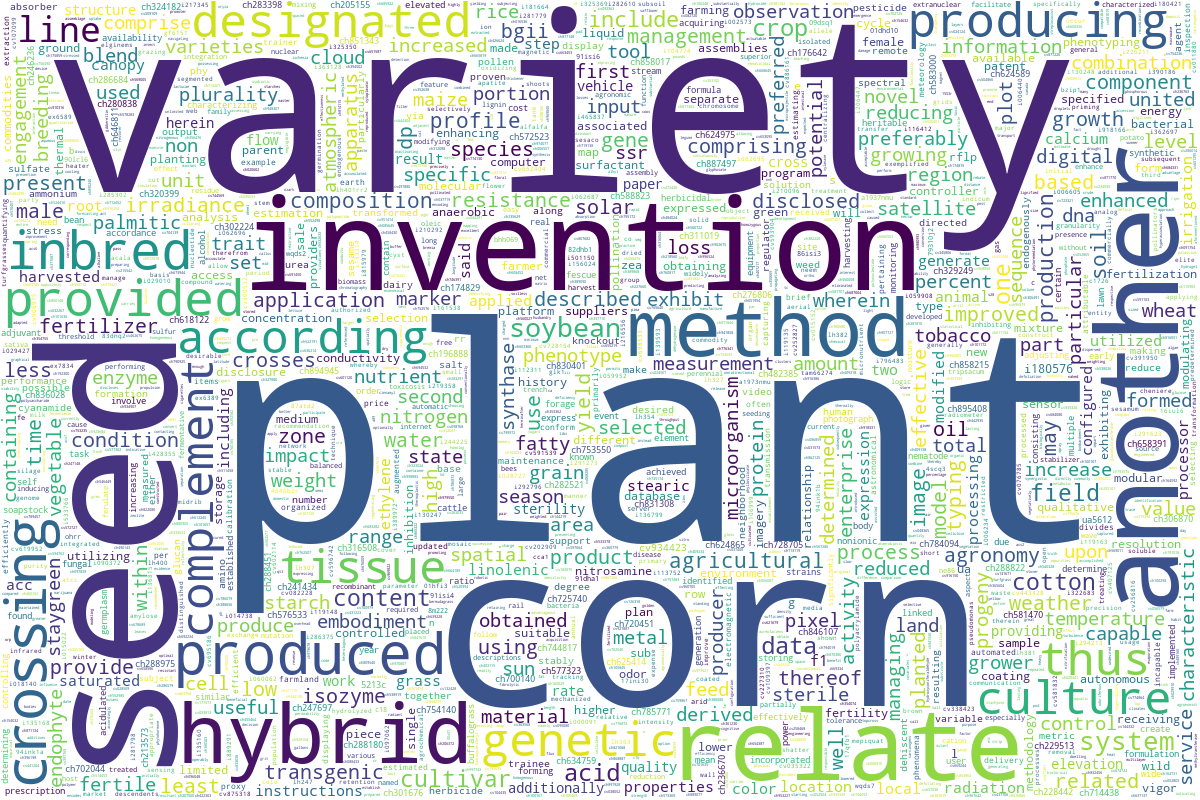

In [60]:
wordcloud.generate(text)
wordcloud.to_image()

In [64]:
wordcloud.to_file(filename='wordcloud_preprocess.png')

In [65]:
data.shape

(904, 6)

In [66]:
data.to_csv('patents_data.csv', index = False)